<a href="https://colab.research.google.com/github/hanzla-khalid98/challenge-2_AN2DL_2025/blob/main/datapreprocessing_tiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge 2**

---


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## ⚙️ **Libraries Import**

In [1]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline



PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [ ]:
!unzip -q "/content/drive/MyDrive/data/an2dl2526c2v2.zip" -d "/content/drive/MyDrive/data/"


replace /content/drive/MyDrive/data/test_data/img_0000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [2]:
# list of files in train_data
files_train = os.listdir("/content/drive/MyDrive/data/train_data/")

images_train = []
masks_train = []

for file in files_train:
  if file.startswith("img"):
    images_train.append(file)
  elif file.startswith("mask"):
    masks_train.append(file)

# list of files in test_data
files_test = os.listdir("/content/drive/MyDrive/data/test_data/")

images_test = []
masks_test = []

for file in files_test:
  if file.startswith("img"):
    images_test.append(file)
  elif file.startswith("mask"):
    masks_test.append(file)

## 🔎 **Exploration and Data Analysis**

In [3]:
n_image_train = len(images_train)
n_mask_train = len(masks_train)

n_image_test = len(images_test)
n_mask_test = len(masks_test)


print(f"training dataset: {n_image_train} images, {n_mask_train} masks")
print(f"testing dataset: {n_image_test} images, {n_mask_test} masks")

training dataset: 691 images, 691 masks
testing dataset: 477 images, 477 masks


In [4]:
df = pd.read_csv("/content/drive/MyDrive/data/train_labels.csv")
df.head()

sample_index            label
0  img_0000.png  Triple negative
1  img_0001.png        Luminal B
2  img_0002.png        Luminal B
3  img_0003.png        Luminal B
4  img_0004.png        Luminal B

In [5]:
# label proportions of train_label.csv

labels = df["label"].value_counts()
print(labels)

label
Luminal B          220
Luminal A          205
HER2(+)            189
Triple negative     77
Name: count, dtype: int64


3 classes are balanced but we need to balance the Triple negative class.

In [6]:
root = "/content/drive/MyDrive/data/"

root_train = root + "train_data/"
root_test = root + "test_data/"

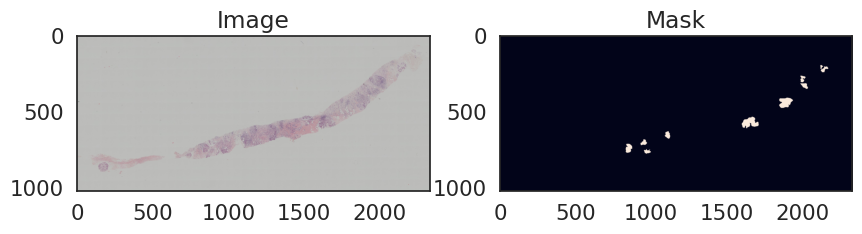

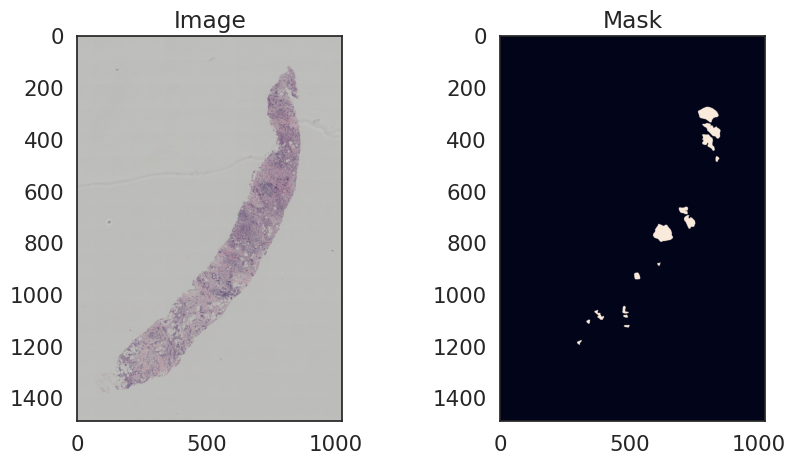

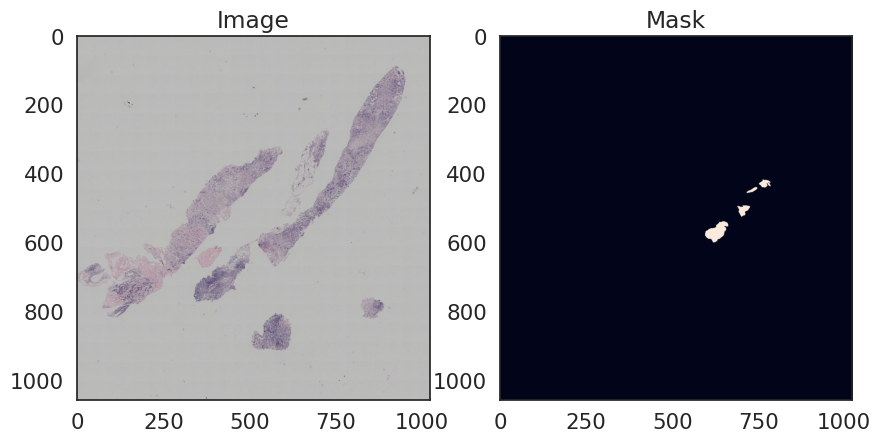

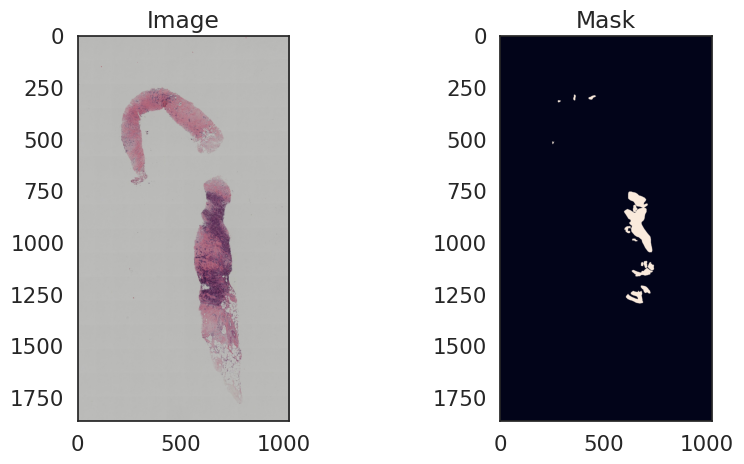

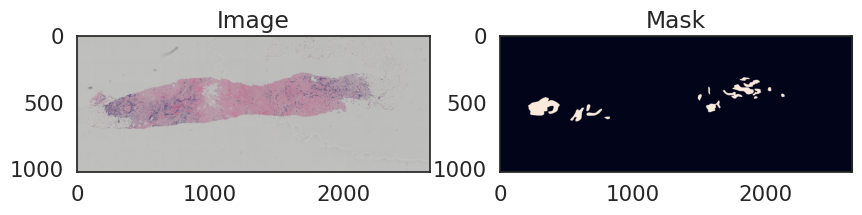

In [8]:
# plot some png images from the train set

# Load the PNG image
for i in range(5):
  image = mpimg.imread(root_train + images_train[i])
  image_number = images_train[i].split("_")[1]
  mask = mpimg.imread(root_train + "mask_" + image_number)
  # Display the image and the mask
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(image)
  axs[0].set_title('Image')
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
  plt.show()


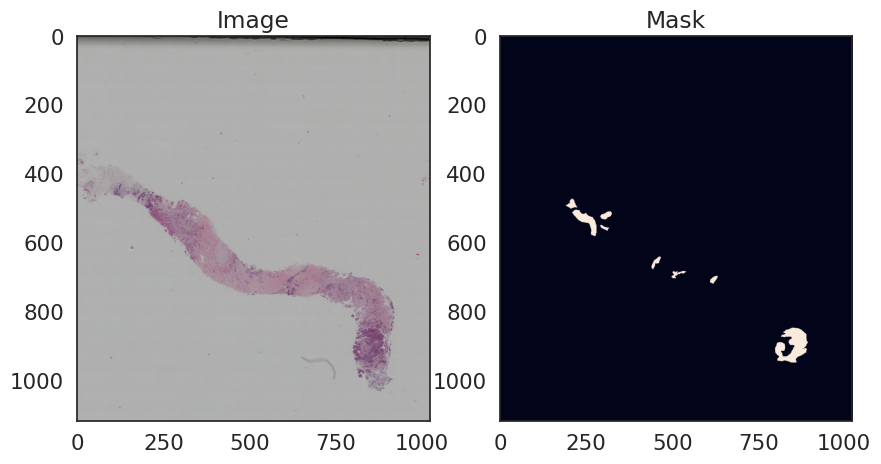

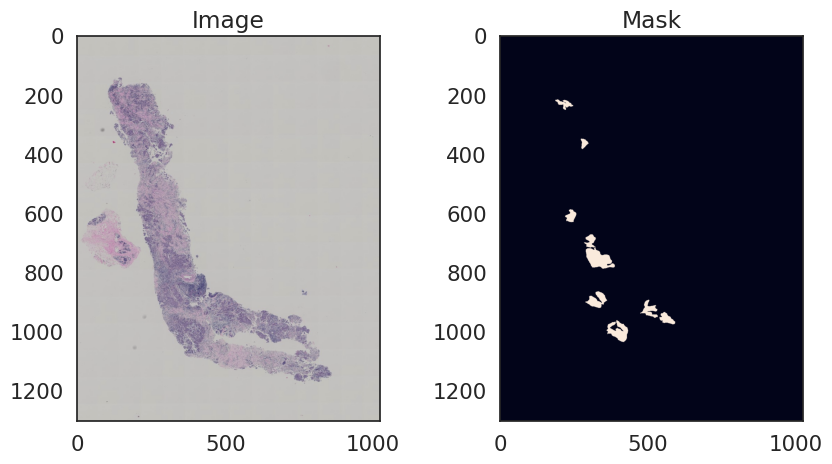

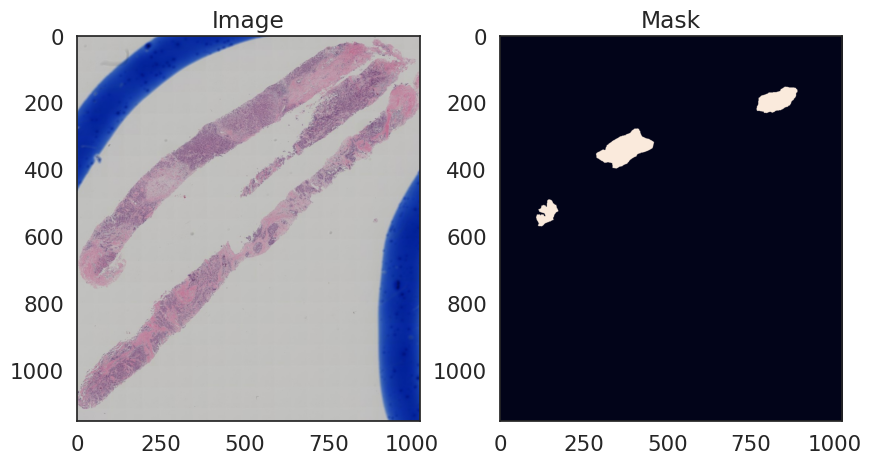

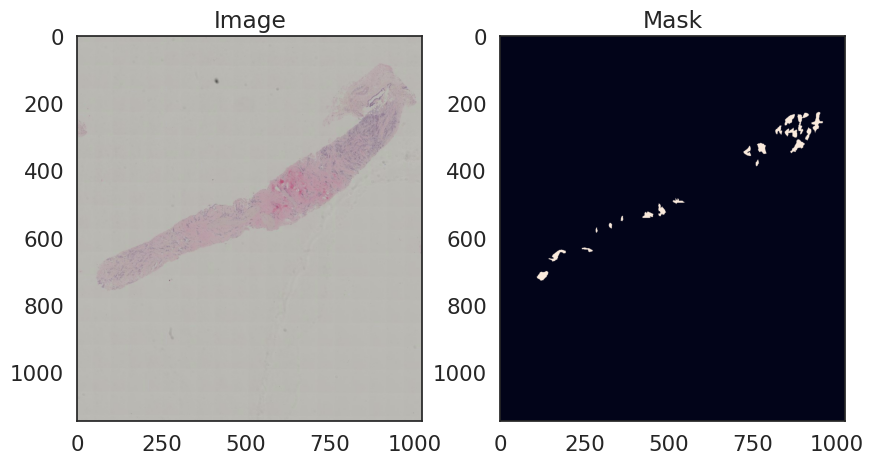

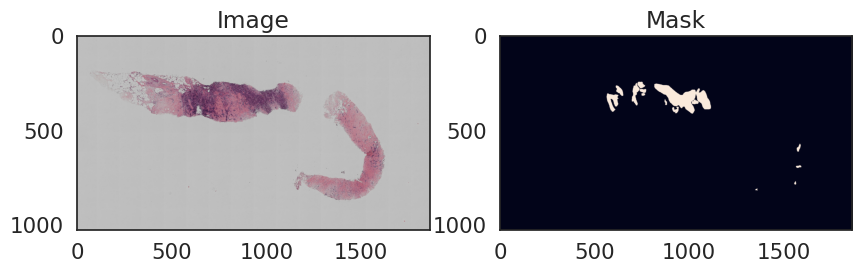

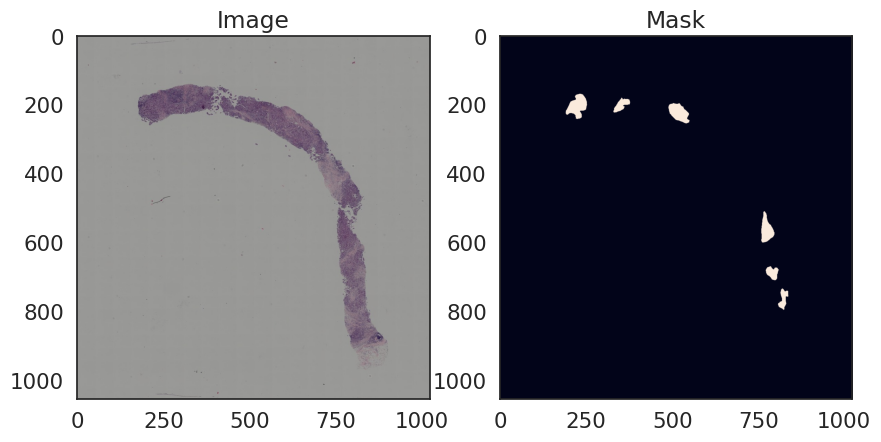

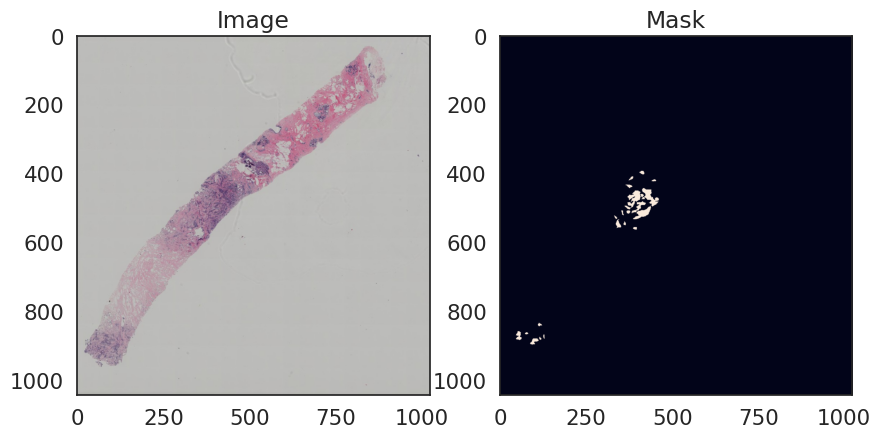

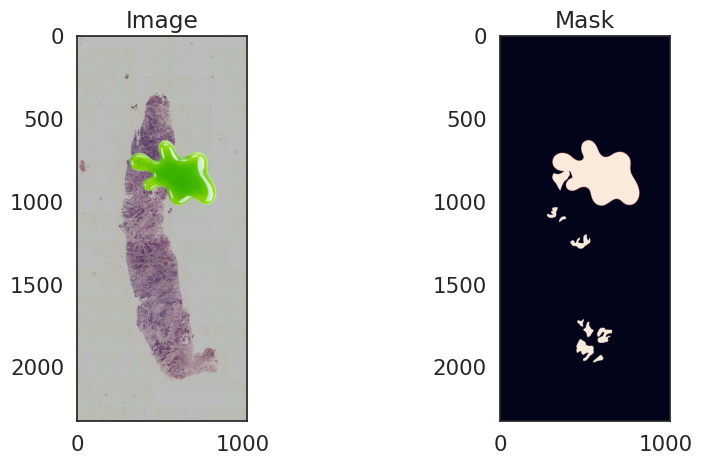

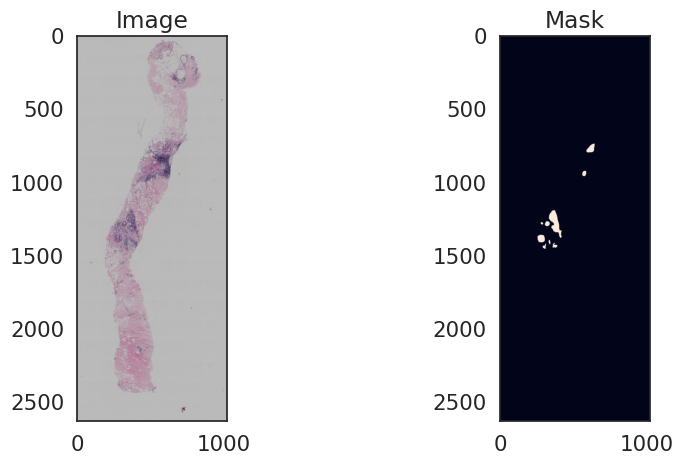

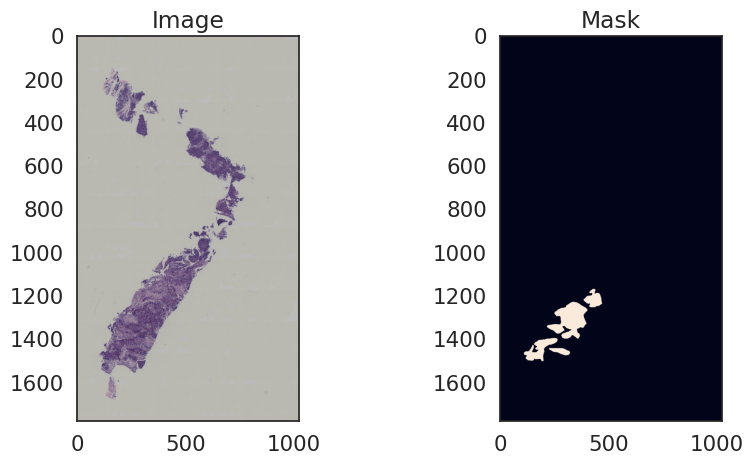

In [ ]:
triple_negative_images = df[df["label"] == "Triple negative"]["sample_index"].tolist()
triple_negative_images

# Load 10 random PNG image from triple_negative
for img in np.random.choice(triple_negative_images, size=10):
  image = mpimg.imread(root_train + img)
  image_number = img.split("_")[1]
  mask = mpimg.imread(root_train + "mask_" + image_number)
  # Display the image and the mask
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(image)
  axs[0].set_title('Image')
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
  plt.show()

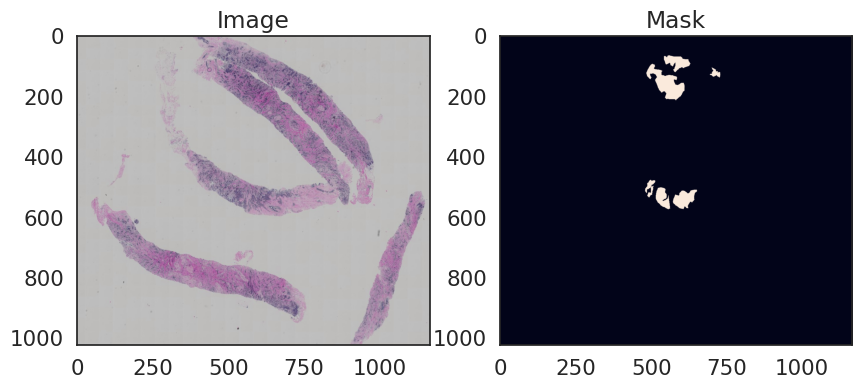

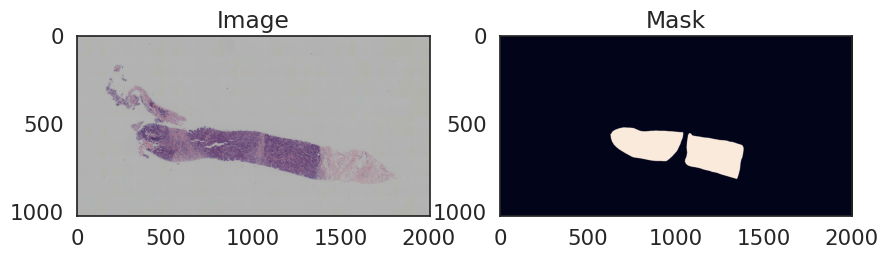

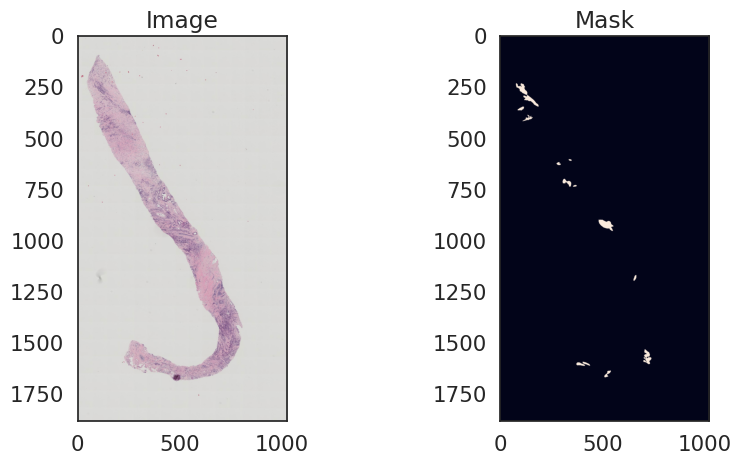

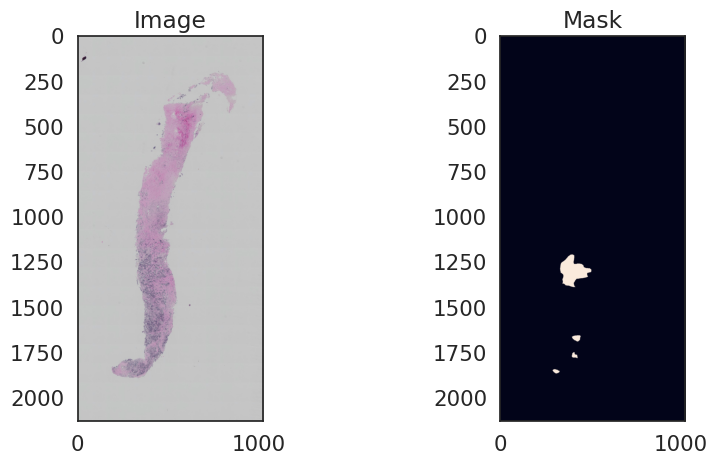

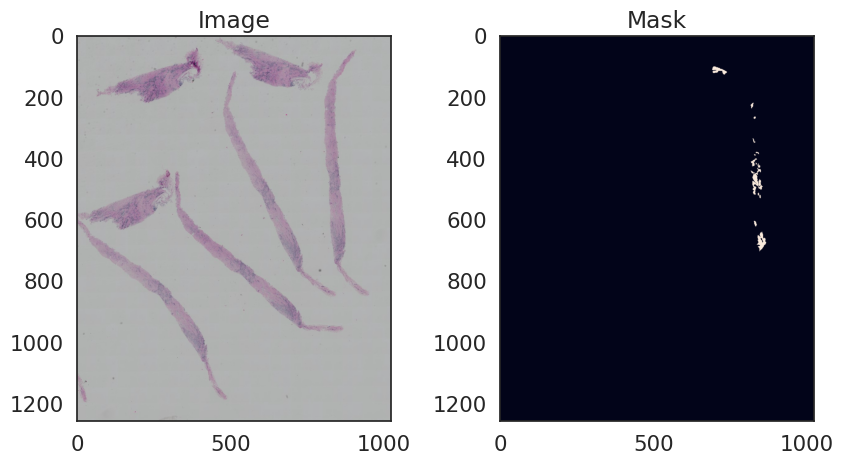

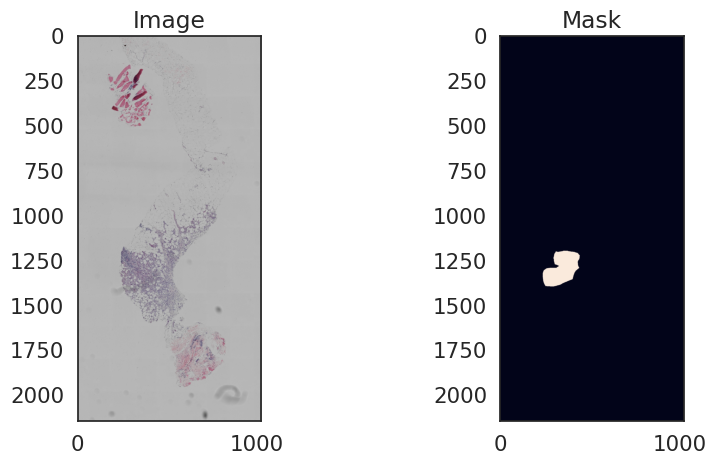

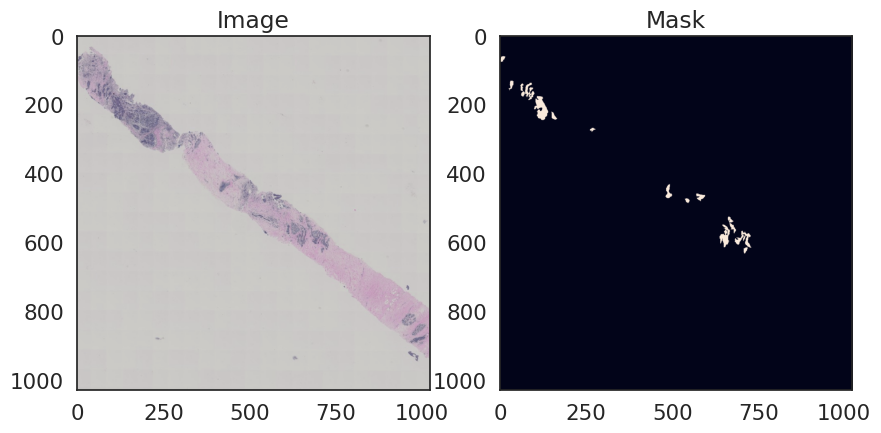

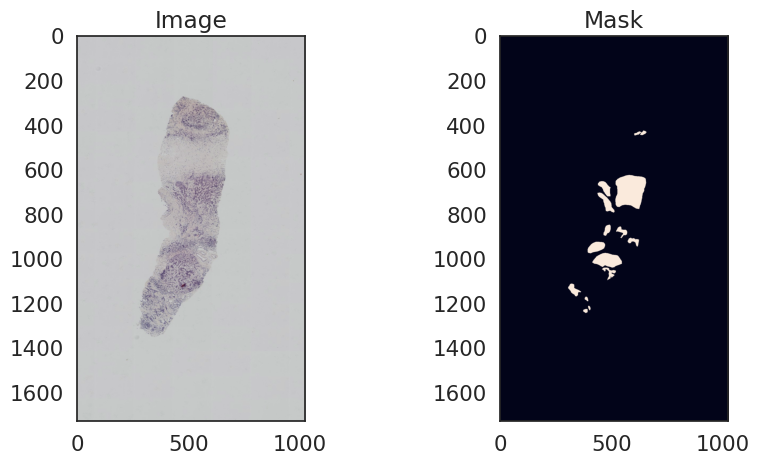

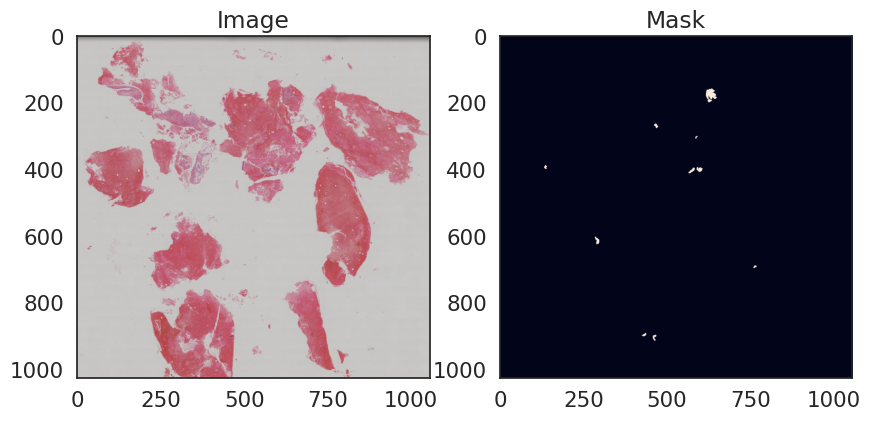

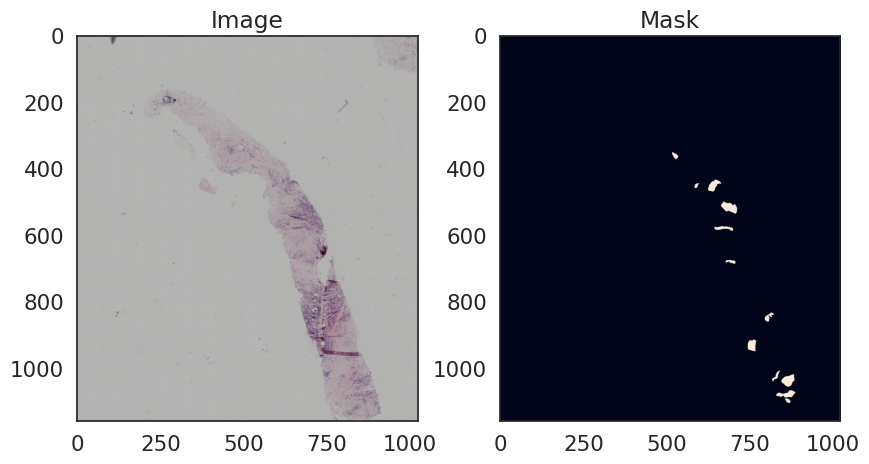

In [ ]:
luminal_A_images = df[df["label"] == "Luminal A"]["sample_index"].tolist()


# Load 10 random PNG image from luminal A
for img in np.random.choice(luminal_A_images, size=10):
  image = mpimg.imread(root_train + img)
  image_number = img.split("_")[1]
  mask = mpimg.imread(root_train + "mask_" + image_number)
  # Display the image and the mask
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(image)
  axs[0].set_title('Image')
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
  plt.show()

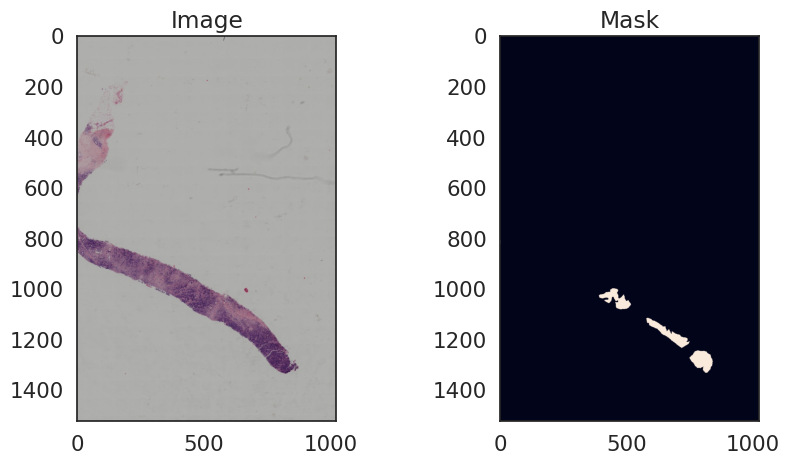

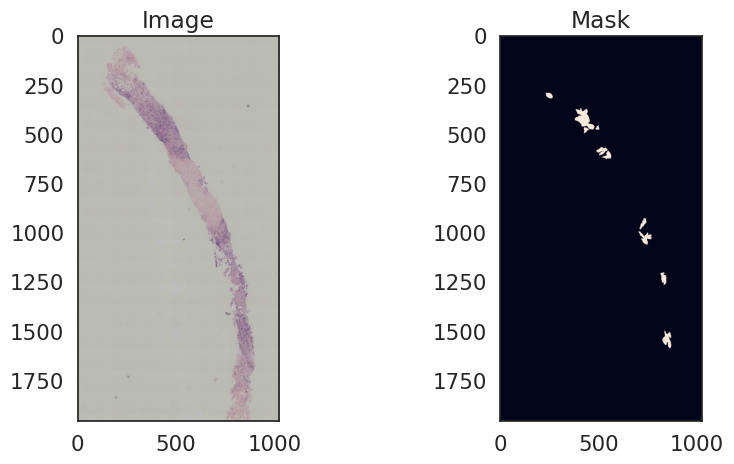

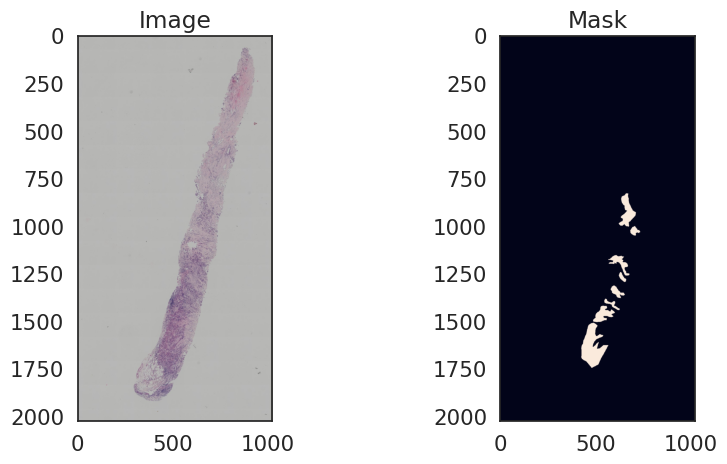

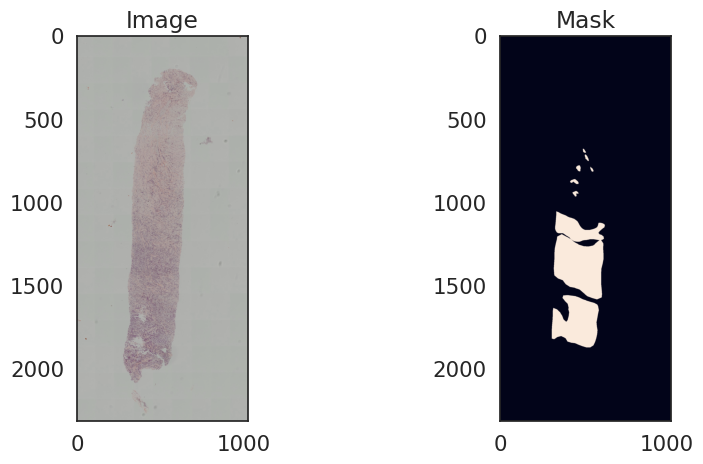

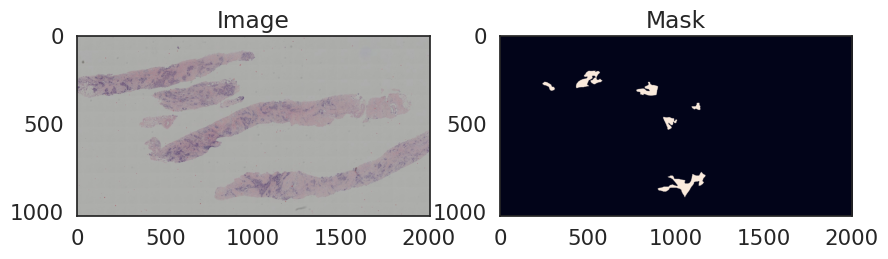

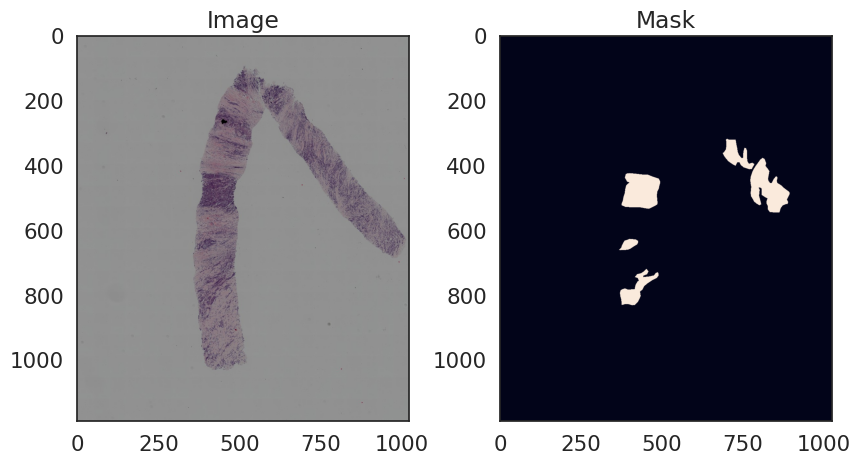

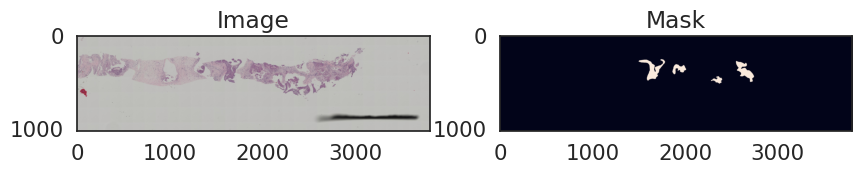

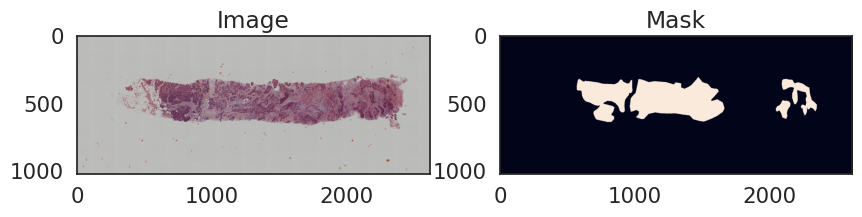

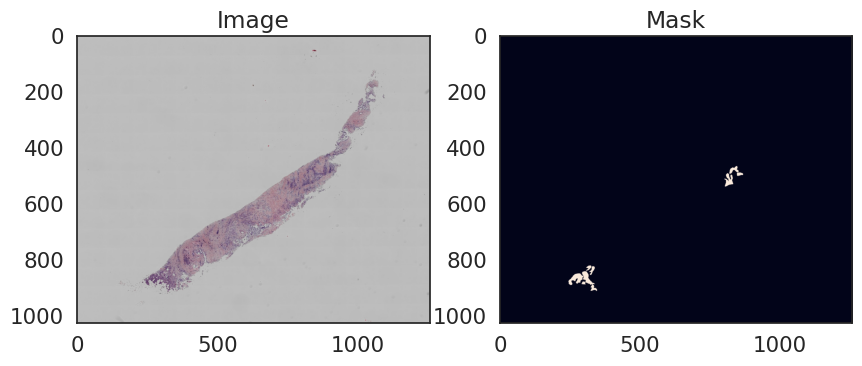

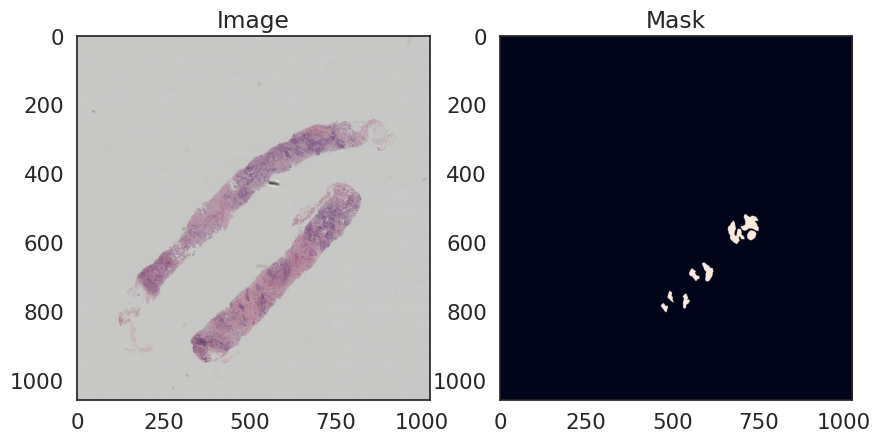

In [ ]:
luminal_B_images = df[df["label"] == "Luminal B"]["sample_index"].tolist()


# Load 10 random PNG image from luminal B
for img in np.random.choice(luminal_B_images, size=10):
  image = mpimg.imread(root_train + img)
  image_number = img.split("_")[1]
  mask = mpimg.imread(root_train + "mask_" + image_number)
  # Display the image and the mask
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(image)
  axs[0].set_title('Image')
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
  plt.show()

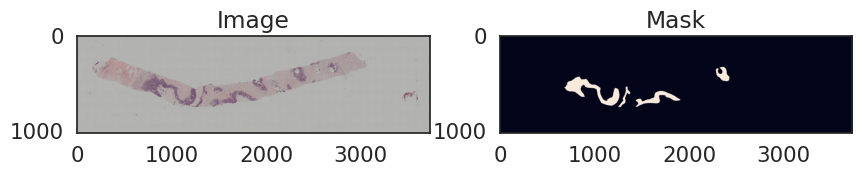

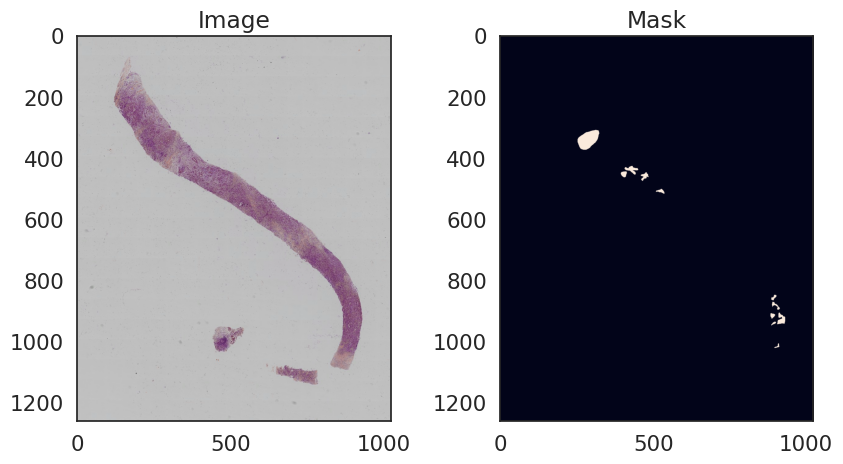

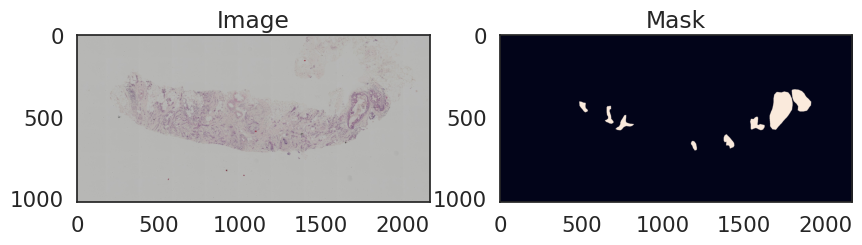

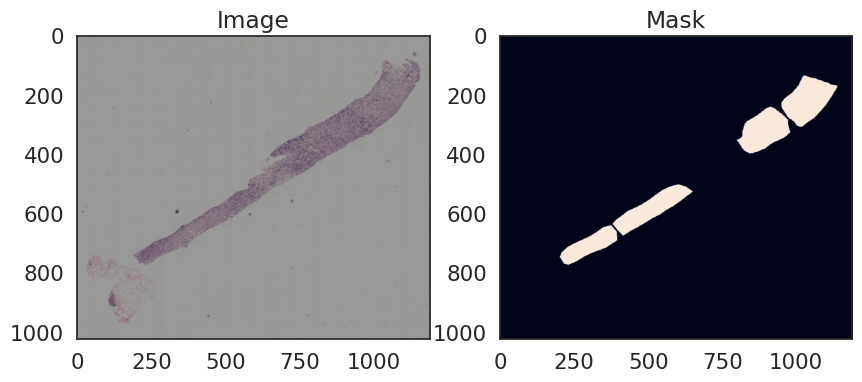

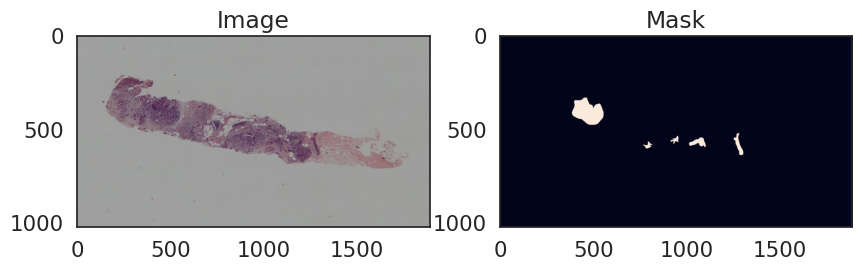

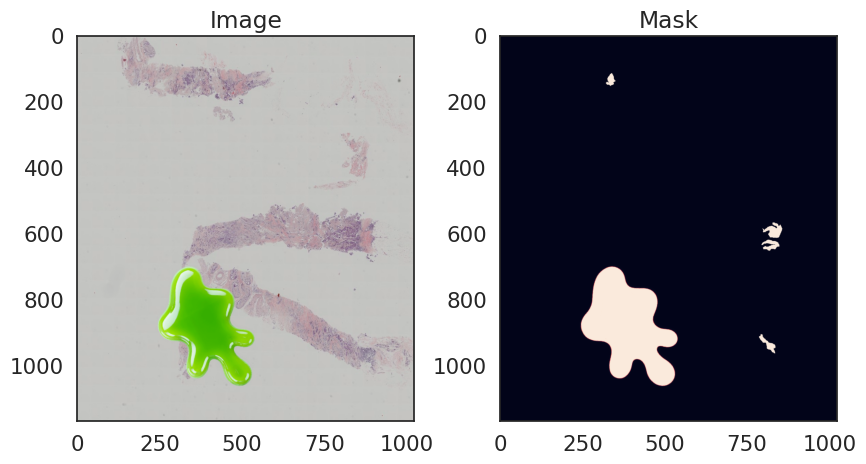

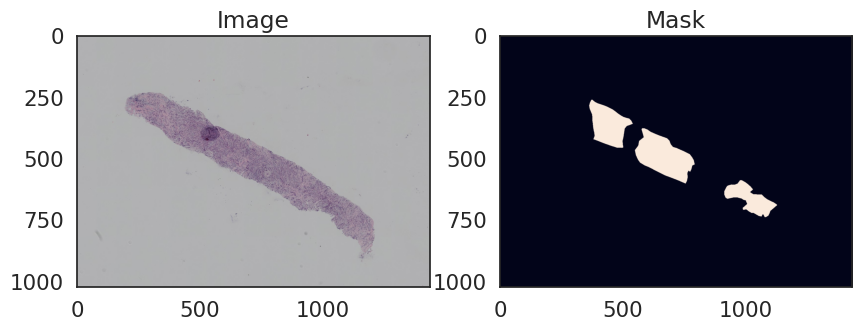

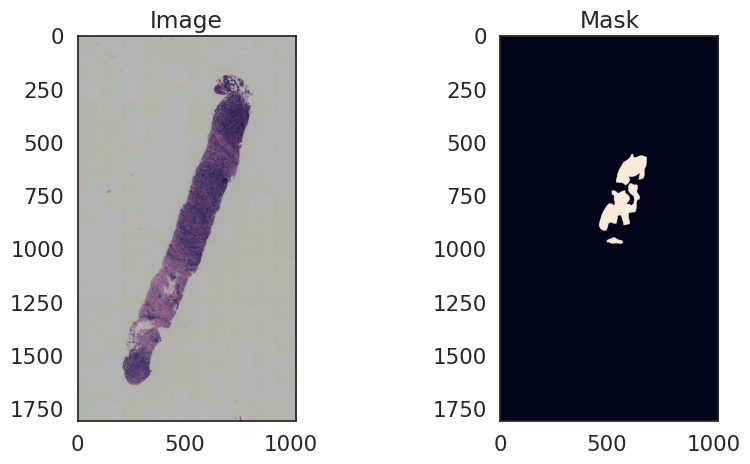

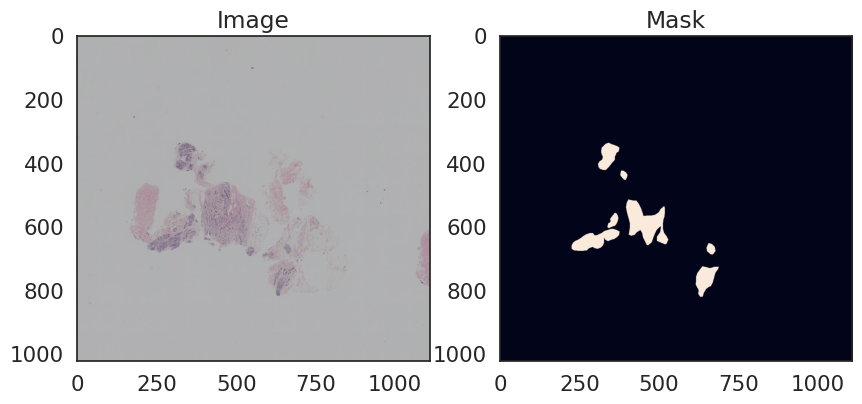

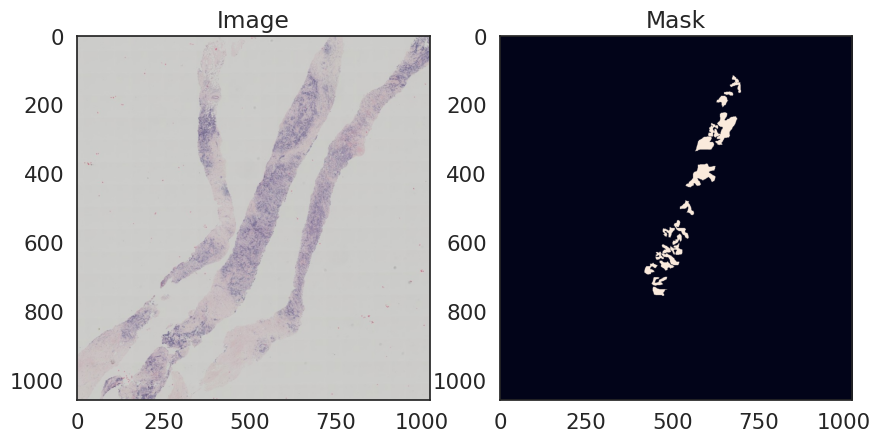

In [ ]:
HER2_images = df[df["label"] == "HER2(+)"]["sample_index"].tolist()


# Load 10 random PNG image from HER2(+)
for img in np.random.choice(HER2_images, size=10):
  image = mpimg.imread(root_train + img)
  image_number = img.split("_")[1]
  mask = mpimg.imread(root_train + "mask_" + image_number)
  # Display the image and the mask
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(image)
  axs[0].set_title('Image')
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
  plt.show()

# Preprocessing by extracting tiles

In [7]:
def extract_roi_tiles(img, mask, tile_size=256, keep_ratio=0.2):
    H, W, _ = img.shape
    tiles = []

    # compute tile grid
    h_tiles = H // tile_size
    w_tiles = W // tile_size

    # collect tiles with ROI score
    scored_tiles = []
    for i in range(h_tiles):
        for j in range(w_tiles):
            y1, y2 = i*tile_size, (i+1)*tile_size
            x1, x2 = j*tile_size, (j+1)*tile_size

            tile_mask = mask[y1:y2, x1:x2]
            score = tile_mask.sum()   # importance measure

            scored_tiles.append((score, img[y1:y2, x1:x2]))

    # select best tiles
    scored_tiles.sort(key=lambda x: x[0], reverse=True)
    k = int(len(scored_tiles) * keep_ratio)
    k = max(k, 1)

    return (np.array([t[1] for t in scored_tiles[:k]]) /255).astype('float16')


In [8]:
import numpy as np
from PIL import Image

# Define the target size for the images. You can modify this as needed.
TARGET_SIZE = (128, 128) # Example: (height, width)

X_train_val_list = []
y_train_val_list = []
X_test_list = []
images_test_name_list = []

# Process training images
nb_images_train = len(images_train)
print("Processing training images...")
for i, img_filename in enumerate(images_train):
    if (i + 1) % 100 == 0 or i == 0 or i == nb_images_train - 1:
        print(f"loading training image: {i + 1}/{nb_images_train}")
    img_path = os.path.join(root_train, img_filename)
    # Open image and mask as PIL objects
    pil_img = Image.open(img_path)
    mask_filename = "mask_" + img_filename.split("_")[1]
    mask_path = os.path.join(root_train, mask_filename)
    pil_mask = Image.open(mask_path)

    # Convert PIL images to NumPy arrays for extract_roi_tiles
    img_np = np.array(pil_img)
    mask_np = np.array(pil_mask)

    # Extract tiles using the NumPy arrays
    tiles = extract_roi_tiles(img_np, mask_np, tile_size=TARGET_SIZE[0], keep_ratio=0.1)

    # create mapping for label of tiles
    label = df[df["sample_index"] == img_filename]["label"].values[0]
    y_train_val_list.extend([label for _ in range(len(tiles))])

    X_train_val_list.extend(tiles)
X_train_val = np.array(X_train_val_list)
y_train_val = np.array(y_train_val_list)
print(f"X_train_val created with shape: {X_train_val.shape}")
print(f"Each training tile is represented as a {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB matrix.\n")


# Process testing images
nb_images_test = len(images_test)
print("Processing testing images...")
for i, img_filename in enumerate(images_test):
    if (i + 1) % 100 == 0 or i == 0 or i == nb_images_test - 1:
        print(f"loading testing image: {i + 1}/{nb_images_test}")
    img_path = os.path.join(root_test, img_filename)
    # Open image and mask as PIL objects
    pil_img = Image.open(img_path)
    mask_filename = "mask_" + img_filename.split("_")[1]
    mask_path = os.path.join(root_test, mask_filename)
    pil_mask = Image.open(mask_path)

    # Convert PIL images to NumPy arrays for extract_roi_tiles
    img_np = np.array(pil_img)
    mask_np = np.array(pil_mask)

    # Extract tiles using the NumPy arrays
    tiles = extract_roi_tiles(img_np, mask_np, tile_size=TARGET_SIZE[0], keep_ratio=0.1)

    # keep the name of image file for each tile
    images_test_name_list.extend([img_filename for _ in range(len(tiles))])

    X_test_list.extend(tiles)
X_test = np.array(X_test_list)
images_test_name = np.array(images_test_name_list)
print(f"X_test_val created with shape: {X_test.shape}")
print(f"Each testing tile is represented as a {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB matrix.")

Processing training images...
loading training image: 1/691
loading training image: 100/691
loading training image: 200/691
loading training image: 300/691
loading training image: 400/691
loading training image: 500/691
loading training image: 600/691
loading training image: 691/691
X_train_val created with shape: (6181, 128, 128, 3)
Each training tile is represented as a 128x128 RGB matrix.

Processing testing images...
loading testing image: 1/477
loading testing image: 100/477
loading testing image: 200/477
loading testing image: 300/477
loading testing image: 400/477
loading testing image: 477/477
X_test_val created with shape: (4414, 128, 128, 3)
Each testing tile is represented as a 128x128 RGB matrix.


In [9]:
print("Training-Validation Data Shape:", X_train_val.shape)
print("Test Data Shape:", X_test.shape)

Training-Validation Data Shape: (6181, 128, 128, 3)
Test Data Shape: (4414, 128, 128, 3)


In [11]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float16')
X_test = (X_test / 255).astype('float16')

In [10]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=SEED, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (5562, 128, 128, 3)
Training Label Shape: (5562,)
Validation Data Shape: (619, 128, 128, 3)
Validation Label Shape: (619,)


In [13]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [11]:
#mapping
class_mapping = {
    "Triple negative": 0,
    "Luminal A": 1,
    "Luminal B": 2,
    "HER2(+)": 3
}

y_train = np.array([class_mapping[label] for label in y_train])
y_val   = np.array([class_mapping[label] for label in y_val])

In [ ]:
X_train.shape

(621, 128, 128, 4)

In [12]:
torch.save({
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'images_test_name': images_test_name
}, '/content/drive/MyDrive/data/dataset_tiling_challenge_2.pt')

In [ ]:
import torch

train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset that applies data augmentation transforms using transforms v2.

    Following the recommended approach from torchvision documentation:
    - Use ToImage() to convert PIL to tensor
    - Use ToDtype(torch.float32, scale=True) to convert to float and scale to [0, 1]

    Args:
        data (np.ndarray): Input images with shape (N, H, W, C)
        labels (np.ndarray): Labels with shape (N,)
        transform (callable, optional): Transform to apply to images
    """
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

        # Base transform: convert to tensor (following v2 guidelines)
        self.to_tensor = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label
        image = self.data[idx]

        # Convert numpy to PIL Image
        image_pil = Image.fromarray((image * 255).astype(np.uint8))

        # Convert to tensor using v2 recommended approach
        image_tensor = self.to_tensor(image_pil)

        # Apply additional transforms if provided
        if self.transform:
            image_tensor = self.transform(image_tensor)

        if self.labels is None:
            return image_tensor
        label = self.labels[idx]

        return image_tensor, torch.tensor(label, dtype=torch.long)


In [ ]:
train_ds = AugmentedDataset(X_train, y_train, transform=train_augmentation)
val_ds   = AugmentedDataset(X_val, y_val, transform=None)
test_ds  = AugmentedDataset(X_test, labels=None, transform=None)

In [ ]:
train_ds.data.shape


(1270, 128, 128, 3)

In [ ]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 256

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([256, 3, 32, 32])
Labels batch shape: torch.Size([256])
